In [1]:
#use pol-stats environment

import pandas as pd
import numpy as np
import os
import cv2
from scipy.optimize import curve_fit
import colorcet as cc

import bokeh.io
import bokeh.plotting
import bokeh.models

import matplotlib.pyplot as plt
import matplotlib as mpl

from utils_calibration import *

bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
trackmate_file = '/Volumes/ursic/Projects/extract_material_properties/calibration_magnetic_tweezers/0_data/20230904_PS_calibration_PCB/TrackMate/20230904_calibration_PCB_s01_1000mV_2.csv'
filename = '20230904_calibration_PCB_s01_1000mV_2'

tip_file = '/Volumes/ursic/Projects/extract_material_properties/calibration_magnetic_tweezers/0_data/20230904_PS_calibration_PCB/20230904_calibration_PCB_s01_before.tif'

filename = os.path.basename(trackmate_file).split('.')[0]

dt = 0.5 #s 
pixel_size = 0.647 # um

df = pd.read_csv(trackmate_file, skiprows=[1, 2, 3], encoding='utf-8')
df = df.sort_values(by='FRAME')

df = df[(50<df["FRAME"])]

df

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,VISIBILITY,MANUAL_SPOT_COLOR,MEAN_INTENSITY_CH1,MEDIAN_INTENSITY_CH1,MIN_INTENSITY_CH1,MAX_INTENSITY_CH1,TOTAL_INTENSITY_CH1,STD_INTENSITY_CH1,CONTRAST_CH1,SNR_CH1
15557,ID10346,10346,52,3.834323,22.135196,386.833941,0.0,25.5,51,4.0,1,NaN,433.756646,431.0,260.0,643.0,212107.0,80.999621,0.188700,1.700172
19221,ID10342,10342,69,6.297510,94.297807,368.664402,0.0,25.5,51,4.0,1,NaN,1419.312883,1329.0,396.0,2683.0,694044.0,623.255659,0.019873,0.088749
15194,ID10345,10345,51,3.905692,27.653946,380.756320,0.0,25.5,51,4.0,1,NaN,394.584867,390.0,207.0,583.0,192952.0,80.467139,0.226866,1.813528
12671,ID10336,10336,43,2.844845,42.612169,355.064124,0.0,25.5,51,4.0,1,NaN,215.286299,169.0,128.0,596.0,105275.0,104.662415,0.209469,0.712493
19922,ID10300,10300,75,1.406719,11.439321,239.917113,0.0,25.5,51,4.0,1,NaN,235.817996,243.0,133.0,333.0,115315.0,40.803377,0.115898,1.200500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,ID31789,31789,13,3.037215,39.465814,259.570747,0.0,179.5,359,4.0,1,NaN,323.443763,322.0,208.0,473.0,158164.0,53.685497,0.215307,2.134736
24329,ID31821,31821,154,3.920116,1.787671,348.854757,0.0,179.5,359,4.0,1,NaN,355.063395,288.0,0.0,905.0,173626.0,180.695169,0.353583,1.026587
7820,ID31807,31807,29,5.945206,72.765123,311.904906,0.0,179.5,359,4.0,1,NaN,413.124744,334.0,194.0,984.0,202018.0,185.707152,0.266389,0.935904
7100,ID31804,31804,27,3.717114,18.247793,308.217235,0.0,179.5,359,4.0,1,NaN,427.576687,371.0,218.0,896.0,209085.0,155.874906,0.116466,0.572298


## Find tip

In [3]:
threshold_tip = 210

img = cv2.imread(tip_file, cv2.IMREAD_UNCHANGED)

tip_outline, tip_end, tip_mask = find_tip(tip_file, threshold_tip, save_img_to_path=False) # in pixels

p = bokeh.plotting.figure(width=400, height=400, title="Yay, we found a tip!!!")
p.x_range.range_padding = p.y_range.range_padding = 0
p.image(image=[img], x=0, y=0, dw=1024, dh=1024)
p.circle(x=tip_outline[:, 0], y=tip_outline[:, 1], color='red')
p.star(x=tip_end[0], y=tip_end[1], color='cyan', size=15)
bokeh.io.show(p)

1024 1024


## Plot trajectories

In [4]:
tip_outline = np.multiply(pixel_size, tip_outline)
tip_end = np.multiply(pixel_size, tip_end)

In [5]:
df['DISTANCE [um]'] = distance_from_tip(tip_outline, df)
df_filtered = filter_tracks(df, tip_mask, pixel_size)

In [6]:
p = bokeh.plotting.figure(
    frame_width = 400,
    frame_height = 400,
    x_axis_label='x [um]',
    y_axis_label='y [um]',
    title=filename
)

p.circle(x=tip_outline[:, 0], y=tip_outline[:, 1], color='red')
p.circle(x=tip_outline[:, 0], y=tip_outline[:, 1], color='gray', alpha = 0.01, size=30)
p.star(x=tip_end[0], y=tip_end[1], color='cyan', size=15)
p.circle(x=df['POSITION_X'], y=df['POSITION_Y'], legend_label='all tracks')
p.circle(x=df_filtered['POSITION_X'], y=df_filtered['POSITION_Y'], color='magenta', legend_label='used tracks')

bokeh.io.show(p)

30


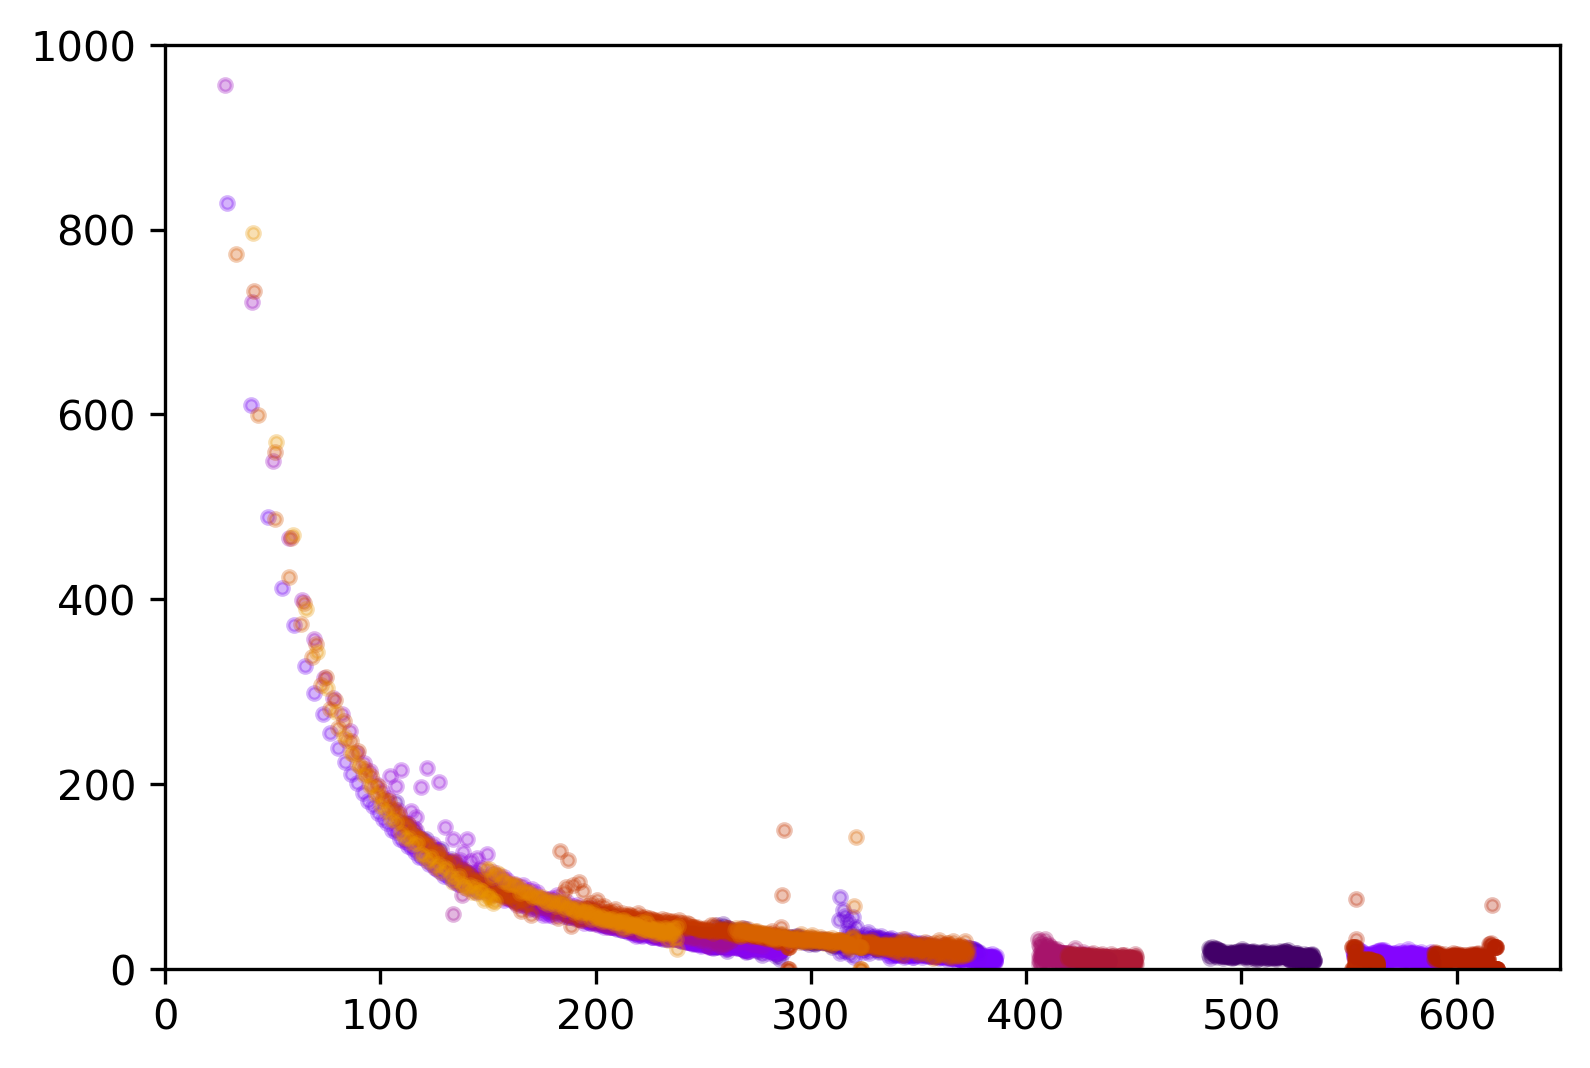

In [7]:
# add velocity x and y components
df = add_velocity_to_df(df_filtered)

df['VELOCITY MAGNITUDE [um/s]'] = velocities(df)
df['FORCE [pN]'] = velocity2force(df['VELOCITY MAGNITUDE [um/s]'])

df = df.dropna(subset='FORCE [pN]')

# Choose the colormap ('gnuplot')
cmap = plt.get_cmap('gnuplot')

n_colors = len(df["TRACK_ID"].unique())+5
print(n_colors)
# Generate discrete colors by sampling the colormap
colors = [cmap(i / n_colors) for i in range(2, n_colors)]


distance = []
force = []

fig = plt.figure(figsize=(6, 4), dpi=300)

for (i, idx) in enumerate(df["TRACK_ID"].unique()):
    if idx in [151, 130, 90]:
        continue
    plt.plot(df.loc[df['TRACK_ID']==idx, "DISTANCE [um]"], df.loc[df['TRACK_ID']==idx, 'FORCE [pN]'], '.', color=colors[i], alpha =0.3, label=f'{idx}')
    distance += list(df.loc[df['TRACK_ID']==idx, "DISTANCE [um]"].values)
    force += list(df.loc[df['TRACK_ID']==idx, 'FORCE [pN]'].values)
plt.xlim(left=0)
plt.ylim(0, 1000)
# plt.legend()
plt.show()

Fit parameters for double curve: f(x) = a1*exp(-x*k1) + a2*exp(-x*k2) 
 a1 = 1748.9849739949248 +- 33.16772031876715 
 k1 = 0.02760243534962151 +- 7.538005278904538e-09 
 a2 = 126.56452466086357 +- 1.8114630300994132 
 k2 = 0.005086754588626805 +- 1.227290487249226e-09 



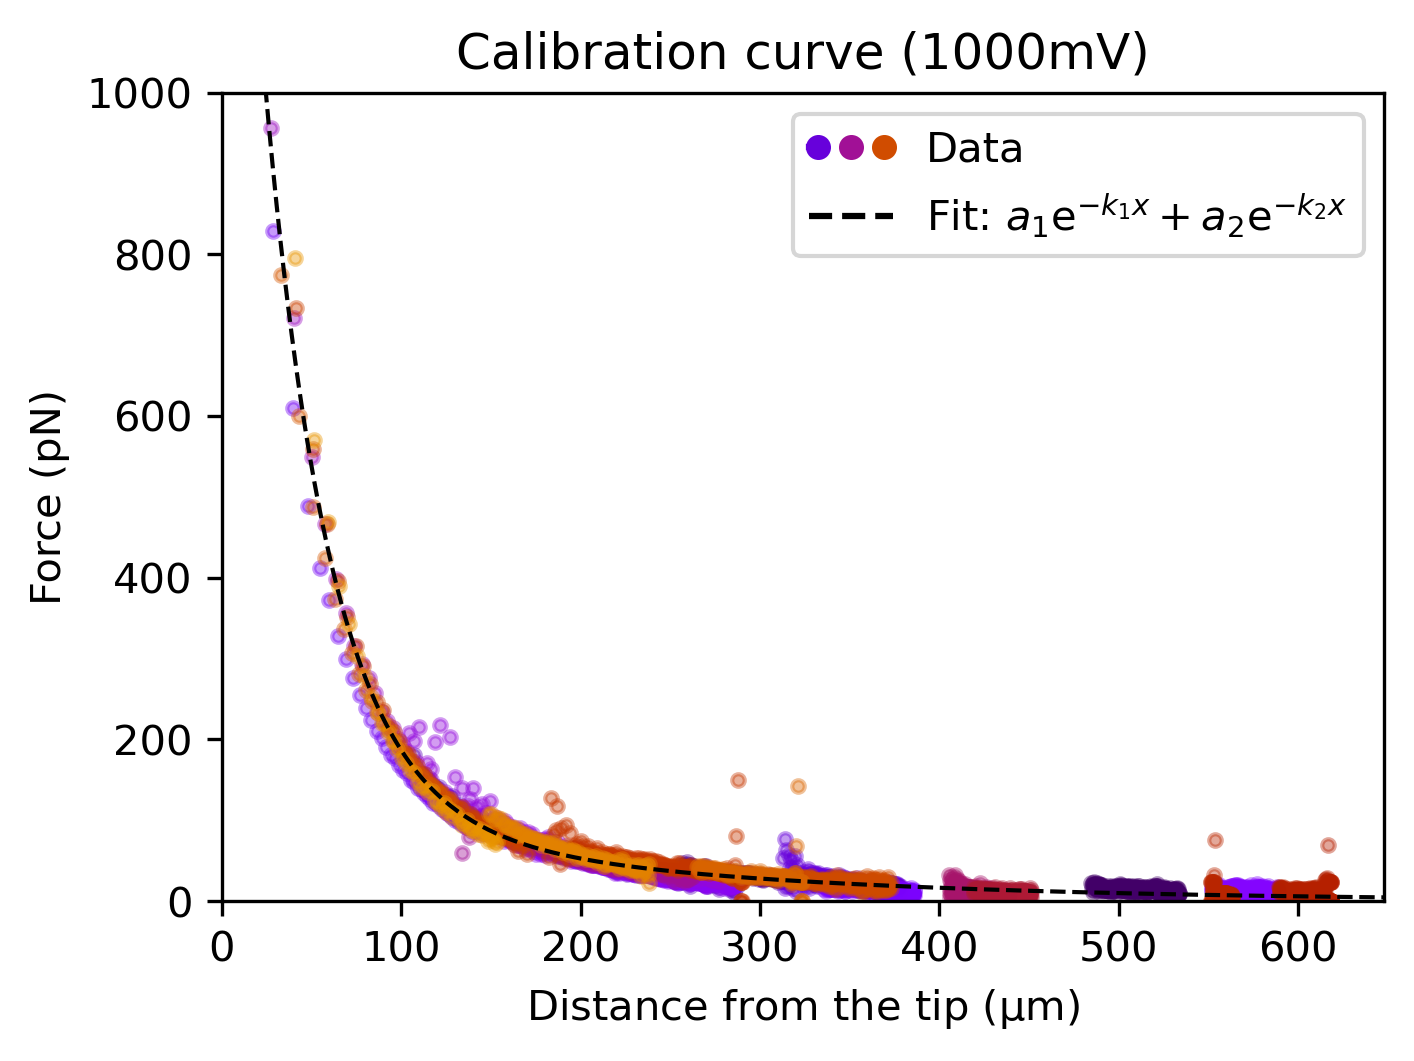

[1.74898497e+03 2.76024353e-02 1.26564525e+02 5.08675459e-03]


In [12]:
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

# fig = plt.figure(figsize=(6, 4))
# plt.plot(distance, force, '.', color= 'gray', alpha =0.2)

x2 = np.linspace(20, 650, 300)
popt2, pcov2 = curve_fit(double_exp, distance, force, p0=[1000, 0.1, 1000, 0.1])
y2 = double_exp(x2, *popt2)

print(f"Fit parameters for double curve: f(x) = a1*exp(-x*k1) + a2*exp(-x*k2) \n",
      f"a1 = {popt2[0]} +- {pcov2[0][0]} \n",
      f"k1 = {popt2[1]} +- {pcov2[1][1]} \n",
      f"a2 = {popt2[2]} +- {pcov2[2][2]} \n",
      f"k2 = {popt2[3]} +- {pcov2[3][3]} \n")

fig = plt.figure(figsize=(5, 3.5), dpi=300)

for (i, idx) in enumerate(df["TRACK_ID"].unique()):
    if idx in [151, 130, 90]:
        continue
    plt.plot(df.loc[df['TRACK_ID']==idx, "DISTANCE [um]"], df.loc[df['TRACK_ID']==idx, 'FORCE [pN]'], '.', color=colors[i], alpha = 0.4)
    distance += list(df.loc[df['TRACK_ID']==idx, "DISTANCE [um]"].values)
    force += list(df.loc[df['TRACK_ID']==idx, 'FORCE [pN]'].values)
plt.xlim(left=0)
plt.ylim(0, 1000)


plt.plot(x2, y2, 'k--', linewidth=1, label='$y = a_1 \mathrm{exp}(-k_1x) + a_2 \mathrm{exp}(-k_2x)$')
plt.plot([], [], '.', color=colors[5], alpha = 0.4, label='Data')


file=filename.split(r'/')[-1]
plt.title(f'Calibration curve (1000mV)')
plt.xlabel("Distance from the tip ($\mathrm{\mu}$m)")
plt.ylabel('Force (pN)')
# plt.yscale('log')
# plt.xscale('log')


red_marker =  Line2D([0], [0], marker='o', color=colors[3], markersize=5)
blue_marker = Line2D([0], [0], marker='o', color=colors[10], markersize=5)
green_marker = Line2D([0], [0], marker='o', color=colors[18], markersize=5)
fit_marker = Line2D([0], [0], linestyle='--', color='k')


# Custom legend: combining the three markers into one label
# Combine markers into one legend entry
plt.legend([(red_marker, blue_marker, green_marker), fit_marker], ['Data', 'Fit: $a_1 \mathrm{e}^{-k_1x} + a_2 \mathrm{e}^{-k_2x}$'], handler_map={tuple: HandlerTuple(ndivide=None)})


# plt.savefig('/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/3_plots/results/calibration_1000mV.svg', format='svg')
plt.show()

print(popt2)